In [1]:
import numpy as np
import torch
import sys
sys.path.append('../')
from voting_games.werewolf_env_v0 import plurality_env, pare, Phase, Roles
import random
import copy
from tqdm import tqdm
from collections import Counter
import matplotlib.pyplot as plt
from notebooks.learning_agents.models import ActorCriticAgent
from notebooks.learning_agents.utils import play_recurrent_game, convert_obs
from notebooks.learning_agents.static_agents import random_approval_wolf, random_plurality_wolf
import mlflow

/root/.local/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Training Agents 

Because we used PPO to train our actor-critic truncated BPTT LSTM, we modified our code to closely resemble the work done in {cite}`pleines2022memory`.
The steps we follow are very closely related to our [PPO Algorithm](ppo-alg-header).

We first create a trainer class that stores our config and uses it to set up our buffer, our central villager policy and our optimizer.

```python
class PPOTrainer:
    def __init__(self, env, config:dict, wolf_policy, run_id:str="run", device:torch.device=torch.device("cpu"), voting_type:str=None) -> None:
```

We then call our train function which sets up the main loop consisting of gatheric metrics periodically, filling up our buffer, calculating our loss and updating our neural network.

```python
def train(self, voting_type=None, save_threshold=50.0):

    # TODO: put mlflow logging into a callback
    mlflow.log_params(self.config["config_training"]["training"])
    mlflow.log_params(self.config["config_training"]["model"])
    mlflow.log_params(self.config["config_game"]['gameplay'])

    loop = tqdm(range(self.config["config_training"]["training"]["updates"]), position=0)

    # if the average wins when we do periodic checks of the models scoring is above the save threshold, we save or overwrite the model
    # model_save_threshold = 50.0
    for tid, _ in enumerate(loop):

        if tid % 10 == 0:
            # print(f'Playing games with our trained agent after {epid} epochs')
            loop.set_description("Playing games and averaging score")
            wins = []
            score_gathering = tqdm(range(10), position=1, leave=False)
            replays = []
            for _ in score_gathering:
                game_wins, game_replays = play_recurrent_game(self.env, 
                                                self.wolf_policy, 
                                                self.agent, 
                                                num_times=100,
                                                hidden_state_size=self.config["config_training"]["model"]["recurrent_hidden_size"],
                                                voting_type=voting_type)
                wins.append(game_wins)
                replays.append(game_replays)
                score_gathering.set_description(f'Avg wins with current policy : {np.mean(wins)}')

            # flatten all of our replays and get our current stats
            mlflow.log_metrics(aggregate_stats_from_replays(
                [replay for game_replays in replays for replay in game_replays], voting_type=voting_type))

            mlflow.log_metric("avg_wins/100", np.mean(wins))
            if np.mean(wins) > save_threshold:
                save_threshold = int(np.mean(wins))
                mlflow.pytorch.log_state_dict(self.agent.state_dict(), artifact_path='checkpoint')
                # torch.save(self.agent.state_dict(), f'{voting_type}_agent_{self.config["config_game"]["gameplay"]["num_agents"]}_score_{save_threshold}')


        loop.set_description("Filling buffer")
        # fill buffer
        # _scaled_rewards
        buff = fill_recurrent_buffer_scaled_rewards(self.buffer, 
                                        self.env,
                                        self.config["config_training"],
                                        self.wolf_policy, 
                                        self.agent,
                                        voting_type=voting_type)

        # train info will hold our metrics
        train_info = []
        # TODO List how many items we are training on
        loop.set_description(f'Epoch Training on {self.buffer.games} games')
        for _ in range(self.config['config_training']["training"]['epochs']):
            # run through batches and train network
            for batch in buff.get_minibatch_generator(self.config['config_training']["training"]['batch_size']):
                train_info.append(calc_minibatch_loss(self.agent, 
                                                        batch, 
                                                        clip_range=self.config['config_training']["training"]['clip_range'], 
                                                        beta=self.config['config_training']["training"]['beta'], 
                                                        v_loss_coef=self.config['config_training']["training"]['value_loss_coefficient'],
                                                        grad_norm=self.config['config_training']["training"]['max_grad_norm'],
                                                        optimizer=self.optimizer))

        train_stats = np.mean(train_info, axis=0)
        mlflow.log_metric("policy loss", train_stats[0])
        mlflow.log_metric("value loss", train_stats[1])
        mlflow.log_metric("total loss", train_stats[2])
        mlflow.log_metric("entropy loss", train_stats[3])
```

We calculate the loss per mini-batch, which is also a hypeparameter choice. This works for both approval and plurality models due to the policy outputs being in an array. We return and average out the policy, value, entropy and total losses. 

```python
def calc_minibatch_loss(agent, samples: dict, clip_range: float, beta: float, v_loss_coef: float, grad_norm: float, optimizer):
    policies, values, _ = agent(samples['observations'], (samples['hxs'].detach(), samples['cxs'].detach()))
    
    log_probs, entropies = [], []
    for i, policy_head in enumerate(policies):
        # append the log_probs for 1 -> n other agent opinions
        log_probs.append(policy_head.log_prob(samples['actions'][:,i]))
        entropies.append(policy_head.entropy())
    log_probs = torch.stack(log_probs, dim=1)
    entropies = torch.stack(entropies, dim=1).sum(1).reshape(-1)
    
    ratio = torch.exp(log_probs - samples['logprobs'])

    # normalize advantages
    norm_advantage = (samples["advantages"] - samples["advantages"].mean()) / (samples["advantages"].std() + 1e-8)

    # need to repeat for amount of shape of policies (this way we know how many policy heads we need to watch out for)
    norm_advantage = norm_advantage.unsqueeze(1).repeat(1, agent.num_votes)

    # policy loss w/ surrogates
    surr1 = norm_advantage * ratio
    surr2 = norm_advantage * torch.clamp(ratio, 1.0 - clip_range, 1.0 + clip_range)
    policy_loss = torch.min(surr1, surr2)
    policy_loss = policy_loss.mean()

    # Value  function loss
    clipped_values = samples["values"] + (values - samples["values"]).clamp(min=-clip_range, max=clip_range)
    vf_loss = torch.max((values - samples['returns']) ** 2, (clipped_values - samples["returns"]) ** 2)
    vf_loss = vf_loss.mean()

    # Entropy Bonus
    entropy_loss = entropies.mean()

    # Complete loss
    loss = -(policy_loss - v_loss_coef * vf_loss + beta * entropy_loss)

    # Compute gradients
    optimizer.zero_grad()
    loss.backward()
    torch.nn.utils.clip_grad_norm_(agent.parameters(), max_norm=grad_norm)
    optimizer.step()

    
    return [policy_loss.cpu().data.numpy(),     # policy loss
            vf_loss.cpu().data.numpy(),         # value loss
            loss.cpu().data.numpy(),            # total loss
            entropy_loss.cpu().data.numpy()]    # entropy loss
``` 

(mlflow-info)=
## MLflow

MLflow[^mlflow-tooling] is a powerful and popular MLOps open source tool for end-to-end machine learning lifecycle management. We compared this platform with others and simpler alternatives that just forcused on parameter and metric tracking, however due to the adoption of MLflow in industry, we felt it would be a good addition to the project as a sort of tutorial for any other researchers extending this work.

For every training loop, we track all the associated hyperparameters of the experiment, we also track the following metrics:
- Average villager wins periodically
- Our Policy, Value, Entropy and total loss associated with the PPO algorithm
- [Various indicators](gameplay-indicators-list) we try to use to understand the trained agent behaviors


If the average villager wins passes a threshold, the model dict is stored for future usage, and this new rate is set as the threshold.

## Hyperparameters

There are just under 20 hyperparameters, and can be split between gameplay parameters, neural network model parameters and PPO training parameters. Each value in this configuration object below can be changed, and is passed throughout training functions.

Initializations and hyper-parameter choices were greatly influenced by the exhaustive work in {cite}`Andrychowicz2020-fs` and {cite}`pleines2022memory` for the LSTM portion.

```python
config_training = {
    "model": {
        "recurrent_layers": 1,
        "recurrent_hidden_size": 256, 
        "joint_mlp_size": 128,
        "split_mlp_size": 128,
        "num_votes": 10,
        "approval_states": 3,
    },
    "training" : {
        "batch_size": 256, 
        "epochs": 5, 
        "updates": 501, 
        "buffer_games_per_update": 500, 
        "clip_range": 0.1, 
        "value_loss_coefficient": 0.1, 
        "max_grad_norm": 0.5, 
        "beta": 0.01, 
        "learning_rate": 0.0001, 
        "adam_eps": 1e-5, 
        "gamma": 0.99, 
        "gae_lambda": 0.95, 
    }
}


config_game = {
    "rewards": {
        "day": -1,
        "player_death": -1,
        "player_win": 10,
        "player_loss": -5,
        "self_vote": -1,
        "dead_villager": -1,
        "dead_vote": -1,
        "dead_wolf": 5,
        "no_viable_vote": -1,
        "no_sleep": -1,
    },
    "gameplay": {
        "accusation_phases": 3,
        "num_agents": 10,
        "num_werewolves": 2,
    }
}

config = {
    "config_game": config_game,
    "config_training": config_training,
}
```

## Training Data

In [2]:
# in a docker container
mlflow_client = mlflow.tracking.MlflowClient(tracking_uri="http://mlflow:5000")

In [17]:
# We have organized the runs in such a way
plurality_experiment = mlflow_client.get_experiment_by_name("Plurality Training")
plurality_runs = mlflow_client.search_runs([plurality_experiment.experiment_id])


In [23]:
# plurality_runs[1]

In [21]:
print(plurality_runs[1].info.run_id)
mlflow_client.get_metric_history(run_id=plurality_runs[1].info.run_id, key="avg_wins/100")

d875a208fa6942ce971ab9605bbcca93


[<Metric: key='avg_wins/100', step=0, timestamp=1690269392317, value=3.7>,
 <Metric: key='avg_wins/100', step=0, timestamp=1690269637595, value=4.4>,
 <Metric: key='avg_wins/100', step=0, timestamp=1690269883335, value=4.1>]

In [26]:
mlflow_client.get_metric_history(run_id=plurality_runs[0].info.run_id, key="avg_wins/100")

x = []
y = []
for metric in mlflow_client.get_metric_history(run_id=plurality_runs[0].info.run_id, key="avg_wins/100"):
    


[<Metric: key='avg_wins/100', step=0, timestamp=1690270097738, value=4.1>,
 <Metric: key='avg_wins/100', step=0, timestamp=1690270347765, value=5.2>,
 <Metric: key='avg_wins/100', step=0, timestamp=1690270596778, value=4.3>,
 <Metric: key='avg_wins/100', step=0, timestamp=1690270849331, value=4.9>,
 <Metric: key='avg_wins/100', step=0, timestamp=1690271106673, value=5.5>]

In [32]:
[item.value for item in mlflow_client.get_metric_history(run_id=plurality_runs[0].info.run_id, key="avg_wins/100")]

[4.1, 5.2, 4.3, 4.9, 5.5]

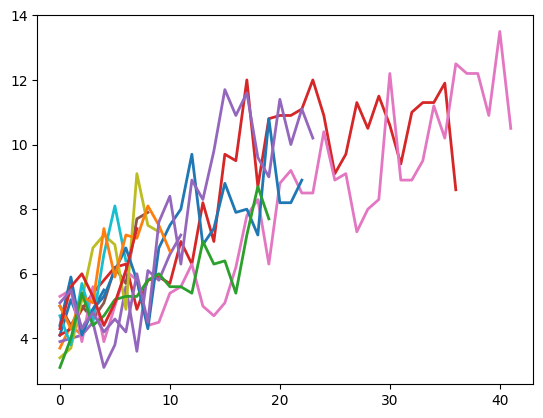

In [33]:
fig, ax = plt.subplots()

for plurality_run in plurality_runs:
    y = [item.value for item in mlflow_client.get_metric_history(run_id=plurality_run.info.run_id, key="avg_wins/100")]
    x = list(range(len(y)))
    ax.plot(x, y, linewidth=2.0)

[^mlflow-tooling]:https://mlflow.org/